In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

from scipy.sparse import diags
from scipy.sparse.linalg import inv 

import numpy.random

In [2]:
# initial condition function 
def I(x):
    L = x[-1]
    len_x = np.size(x)
    i_x = np.zeros(len_x)
    for i in range(len_x):
        if x[i] < (L+1)/2 and x[i] > (L-1)/2:
            i_x[i] = 1
    return i_x

# exact solution
def U_exact(x, t):
    L = x[-1]
    u_ex = np.ones(np.size(x)) * (1/L)
    
    for n in range(1, 2000):
        c_n = (2 / (n * np.pi)) * (np.sin((n * np.pi * (L + 1)) / (2 * L)) - np.sin((n * np.pi * (L - 1)) / (2 * L)))
        
        u_ex += c_n * np.cos(n * np.pi * x / L) * np.exp(-1 * n ** 2 * np.pi ** 2 * t / L ** 2)
        
    return u_ex

In [3]:
# end length & end time
L=10; T=4

# diffusion coefficient 
a = 1

# setting up space part
Nx_spaces = 40 * L; Nt_gaps = 50 * T; 
Nx_points = Nx_spaces +  1 ; Nt_points = Nt_gaps + 1

x = np.linspace(0, L, Nx_points)
dx = x[1] - x[0]

# set up time part
t = np.linspace(0, T, Nt_points)
dt = t[1] - t[0]

# constant for numerical method
C = a * dt / dx ** 2
print("dx=",dx,"dt=", dt,"C =",C)

# set up matrices
u = np.zeros(Nx_points)
u_old = np.zeros(Nx_points)

U2_scrub = np.zeros((Nx_points,Nt_points))
U1_scrub = np.zeros((Nx_points,Nt_points))
U_bigscrub = np.zeros((Nx_points,Nt_points))
U_ex = np.zeros((Nx_points, Nt_points))

# Data structures for the linear system
b = np.zeros(Nx_points)

# set up the matrix A
A = diags([-C, 1 + 2 * C, -C], [-1, 0, 1], shape = (Nx_points, Nx_points))
A = A.toarray()
A[0, 1] = -2 * C
A[-1, -2] = -2 * C


dx= 0.025 dt= 0.02 C = 31.999999999999993


In [6]:
# define a sink term function 
def sink(x):
    return abs(0.25 * x)

In [7]:
# Set initial condition u(x,0) = I(x)
u_old = I(x) 

# initialise matrices U and U_ex2 for first time step
U2_scrub[:,0] = u_old[:]
U_ex[:,0] = U_exact(x,0)
U_bigscrub[:,0] = u_old[:]
U1_scrub[:, 0]

# perform time stepping
for n in range(1, Nt_points): # timestep for 1 to t = T-1 so last step finishes on t=T
    
    # Compute b and solve linear system
    b[:] = u_old[:]
    u[:] = np.linalg.solve(A, b)

    u[100:110] -= 0.25 * dt
    u[200:210] -= 0.25 * dt

    # make sure it does not go negative
    for s in range(len(u)):
        if u[s] < 0:
            u[s] = 0

    u_old = u
    U2_scrub[:,n] = u

    U_ex[:,n] = U_exact(x,t[n])

u_old = I(x) 

# initialise matrices U and U_ex2 for first time step


# perform time stepping
for n in range(1, Nt_points): # timestep for 1 to t = T-1 so last step finishes on t=T
    
    # Compute b and solve linear system
    b[:] = u_old[:]
    u[:] = np.linalg.solve(A, b)

    # Update u_1 before next step and do the sink term 
    u_old = u - sink(u) * dt
    U_bigscrub[:,n] = u - sink(u) * dt

u_old = I(x)
for n in range(1, Nt_points): # timestep for 1 to t = T-1 so last step finishes on t=T
    
    # Compute b and solve linear system
    b[:] = u_old[:]
    u[:] = np.linalg.solve(A, b)

    u[170:180] -= 0.25 * dt

    # make sure it does not go negative
    for s in range(len(u)):
        if u[s] < 0:
            u[s] = 0

    u_old = u
    U1_scrub[:,n] = u

Text(0.5, 0.98, 'the effect of different types of scrubbers on the system')

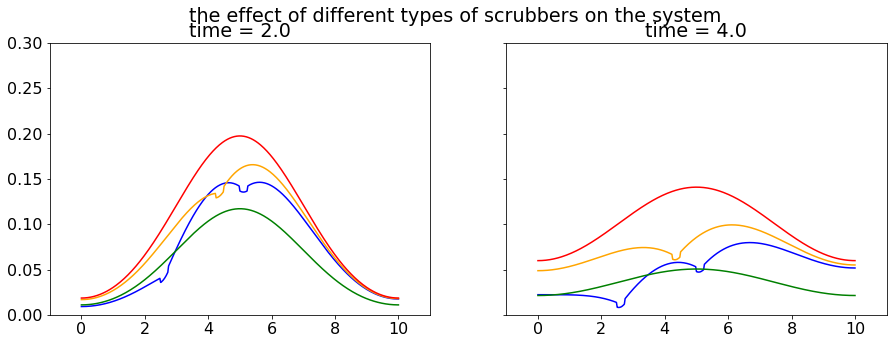

In [19]:
times = np.linspace(0, Nt_gaps, 3, dtype = int)

plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (15, 5))

ax[0].axis([-1, 11, 0, 0.3])
ax[1].axis([-1, 11, 0, 0.3])

ax[0].plot(x, U2_scrub[:, times[1]], 'blue', label = 'two scrubbers')
ax[0].plot(x, U1_scrub[:, times[1]], 'orange', label = 'one scrubber')
ax[0].plot(x, U_bigscrub[:, times[1]], 'green', label = 'global scrubbers')
ax[0].plot(x, U_ex[:, times[1]], 'red', label = 'no scrubbers')
ax[0].set_title(f'time = {t[times[1]]}')

ax[1].plot(x, U2_scrub[:, times[2]], 'blue')
ax[1].plot(x, U1_scrub[:, times[2]], 'orange')
ax[1].plot(x, U_bigscrub[:, times[2]], 'green')
ax[1].plot(x, U_ex[:, times[2]], 'red')
ax[1].set_title(f'time = {t[times[2]]}')

fig.suptitle(f'the effect of different types of scrubbers on the system')